# Titanic ML Deployment Demoda

In [1]:
# Importing all necessary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 

# ML training and tuning 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# Loading and saving models
import pickle

### Exploratory Data Analysis [EDA]

In [2]:
# Loading dataset
df = sns.load_dataset('titanic')

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Selecting categorical columns
df.describe(exclude = 'number')

,sex,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,891,889,891,891,891,203,889,891,891
unique,2,3,3,3,2,7,3,2,2
top,male,S,Third,man,True,C,Southampton,no,True
freq,577,644,491,537,537,59,644,549,537


In [7]:
# Note: used to select the columns with object data type
df.describe(include='O')

,sex,embarked,who,embark_town,alive
count,891,889,891,889,891
unique,2,3,3,3,2
top,male,S,man,Southampton,no
freq,577,644,537,644,549


In [6]:
# Check types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [8]:
# Find the percentage of missing values
df.isna().sum()/df.shape[0]

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

In [9]:
# Find the percentage of missing values
round (df.isna().sum()/df.shape[0], 2)

survived       0.00
pclass         0.00
sex            0.00
age            0.20
sibsp          0.00
parch          0.00
fare           0.00
embarked       0.00
class          0.00
who            0.00
adult_male     0.00
deck           0.77
embark_town    0.00
alive          0.00
alone          0.00
dtype: float64

In [10]:
# Drop column with more than 70% of missing values 'deck'
# Note: any replacement for columns that has high missing values would be worthless

df.drop(columns=['deck'], inplace=True)

In [11]:
# check if data is balanced or not for the target
df.sex.value_counts(normalize=True)

male      0.647587
female    0.352413
Name: sex, dtype: float64

In [12]:
df['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [13]:
df['embark_town'].value_counts()

Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

In [14]:
df['who'].value_counts()

man      537
woman    271
child     83
Name: who, dtype: int64

In [15]:
df['alive'].value_counts()

no     549
yes    342
Name: alive, dtype: int64

In [16]:
df['survived'].value_counts()

0    549
1    342
Name: survived, dtype: int64

In [17]:
df['class'].value_counts()

Third     491
First     216
Second    184
Name: class, dtype: int64

In [18]:
df['pclass'].value_counts()

3    491
1    216
2    184
Name: pclass, dtype: int64

In [19]:
df['parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64

In [20]:
df['sibsp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: sibsp, dtype: int64

## Feature Engineering

In [21]:
## fill in 'embarked' with the most frequent value in column
df['embark_town'].fillna(df['embark_town'].mode().iloc[0], inplace=True)

In [22]:
df['embark_town'].mode()

0    Southampton
dtype: object

In [23]:
df['embark_town'].mode().iloc[0]

'Southampton'

In [24]:
df['age'].mean()


29.69911764705882

In [25]:
round(df['age'].mean())

30

In [26]:
# Fill missing age values with average --> 30 it needs to be a whole number "no decimals"
df['age'].fillna(round(df['age'].mean()), inplace=True)

In [27]:
# Drop duplicate features

# Important Notes:
    # sex (male/female) is the same as who (man/woman), it has child as well, but we have age column too
    # embarked (S/C/Q) is the same as embark_town (Southampton/Cherbourg/Queenstown)
    # survived (0/1) is the same as alive (no/yes)
    # class (first/second/third) in the same as pclass(1/2/3)
    # remove adult_male because we have age and gender is the target.
    
df.drop(columns=['who', 'embarked', 'alive', 'pclass', 'adult_male'], inplace=True)

In [28]:
# Convert boolean to integer for 'alone' values

# Note: Alone is the person how has NO "sibsp" and NO "parch"
df['alone'] = df['alone'].astype(int)

In [29]:
df.head()

,survived,sex,age,sibsp,parch,fare,class,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,Southampton,0
1,1,female,38.0,1,0,71.2833,First,Cherbourg,0
2,1,female,26.0,0,0,7.9250,Third,Southampton,1
3,1,female,35.0,1,0,53.1000,First,Southampton,0
4,0,male,35.0,0,0,8.0500,Third,Southampton,1


In [30]:
# Finding the corelation between variables 

df.corr().style.background_gradient(cmap='coolwarm')

,survived,age,sibsp,parch,fare,alone
survived,1.000000,-0.070657,-0.035322,0.081629,0.257307,-0.203367
age,-0.070657,1.000000,-0.232440,-0.180330,0.090632,0.181165
sibsp,-0.035322,-0.232440,1.000000,0.414838,0.159651,-0.584471
parch,0.081629,-0.180330,0.414838,1.000000,0.216225,-0.583398
fare,0.257307,0.090632,0.159651,0.216225,1.000000,-0.271832
alone,-0.203367,0.181165,-0.584471,-0.583398,-0.271832,1.000000


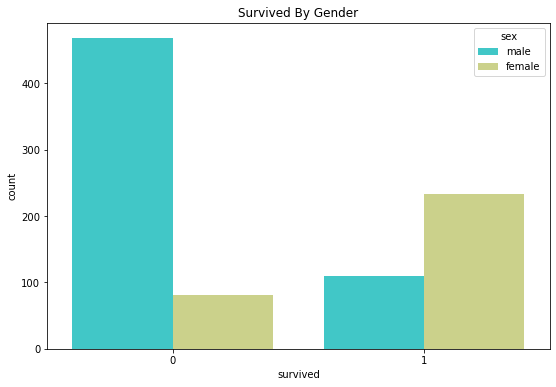

In [31]:
# EDA 

plt.figure(figsize=(9,6))
sns.countplot(x='survived',data=df, hue='sex', palette='rainbow')
plt.title('Survived By Gender')
plt.show()

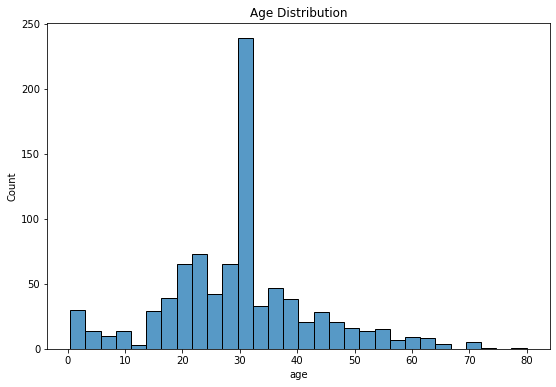

In [32]:
# Note: Our replacement of mising values created a problem... how can we fix it?

plt.figure(figsize=(9,6))
sns.histplot(data=df, x="age", palette='rainbow')
plt.title('Age Distribution')
plt.show()

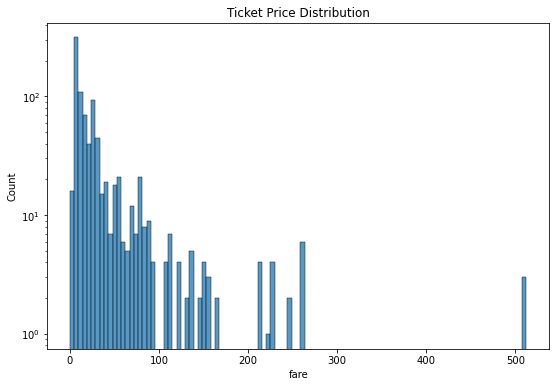

In [33]:
# EDA 

plt.figure(figsize=(9,6))
sns.histplot(data=df, x="fare", palette='rainbow')
plt.title('Ticket Price Distribution')
plt.yscale('log')
plt.show()

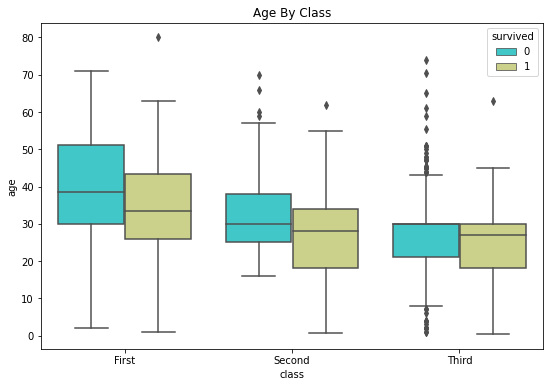

In [34]:
# EDA 

plt.figure(figsize=(9,6))
sns.boxplot(x='class',y='age',data=df, hue='survived', palette='rainbow')
plt.title('Age By Class')
plt.show()

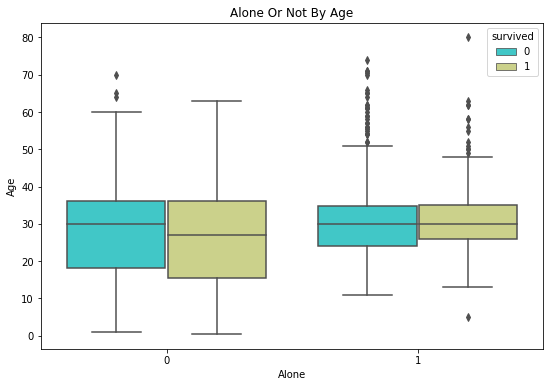

In [35]:
# EDA 

plt.figure(figsize=(9,6))
sns.boxplot(x='alone',y='age',data=df, hue='survived', palette='rainbow')
plt.title('Alone Or Not By Age')
plt.xlabel('Alone')
plt.ylabel('Age')
plt.show()

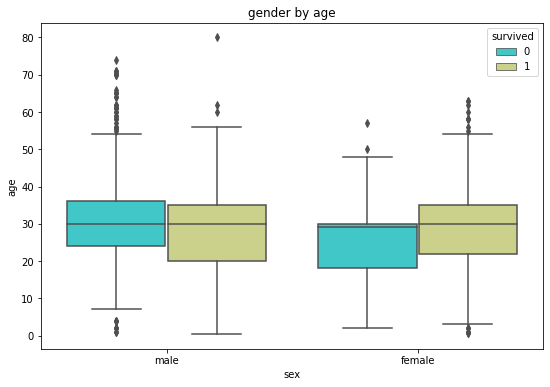

In [36]:
# EDA

plt.figure(figsize=(9,6))
sns.boxplot(x='sex',y='age',data=df, hue='survived', palette='rainbow')
plt.title('gender by age')
plt.show()

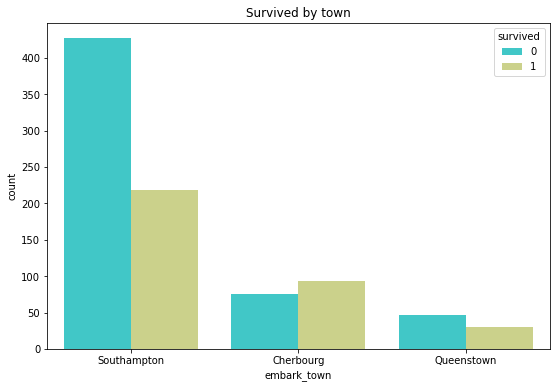

In [37]:
# EDA 

plt.figure(figsize=(9,6))
sns.countplot(x='embark_town',data=df, hue='survived', palette='rainbow')
plt.title('Survived by town')
plt.show()

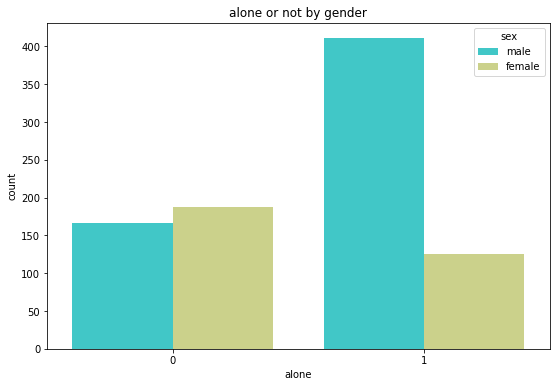

In [38]:
# EDA 

plt.figure(figsize=(9,6))
sns.countplot(x='alone',data=df, hue='sex', palette='rainbow')
plt.title('alone or not by gender')
plt.show()

### Building Machine Learning Model 

In [39]:
# Split dataset to features and target
# Note: Our target in this model is gender

X = df.drop(columns=['sex'])
y = df['sex']

In [40]:
X.head()

,survived,age,sibsp,parch,fare,class,embark_town,alone
0,0,22.0,1,0,7.2500,Third,Southampton,0
1,1,38.0,1,0,71.2833,First,Cherbourg,0
2,1,26.0,0,0,7.9250,Third,Southampton,1
3,1,35.0,1,0,53.1000,First,Southampton,0
4,0,35.0,0,0,8.0500,Third,Southampton,1


In [41]:
# Splitting the dataset to train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state= 42)

In [42]:

X_train.shape, X_test.shape

((668, 8), (223, 8))

In [43]:
# Encoding categorical features

enc = OneHotEncoder()

X_train_enc = enc.fit_transform(X_train[['class', 'embark_town']])

X_test_enc = enc.transform(X_test[['class', 'embark_town']])

In [44]:
enc.categories_[0]

array(['First', 'Second', 'Third'], dtype=object)

In [ ]:
print(X_train_enc.toarray())

In [ ]:
enc.get_feature_names()

In [45]:
# add back encoded columns to dataframe
X_train[enc.get_feature_names()] = X_train_enc.toarray()
X_test[enc.get_feature_names()] = X_test_enc.toarray()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [46]:
X_train.drop(columns=['class', 'embark_town'], inplace=True)
X_test.drop(columns=['class', 'embark_town'], inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [47]:
X_train.head()

,survived,age,sibsp,parch,fare,alone,x0_First,x0_Second,x0_Third,x1_Cherbourg,x1_Queenstown,x1_Southampton
298,1,30.00,0,0,30.5000,1,1.0,0.0,0.0,0.0,0.0,1.0
884,0,25.00,0,0,7.0500,1,0.0,0.0,1.0,0.0,0.0,1.0
247,1,24.00,0,2,14.5000,0,0.0,1.0,0.0,0.0,0.0,1.0
478,0,22.00,0,0,7.5208,1,0.0,0.0,1.0,0.0,0.0,1.0
305,1,0.92,1,2,151.5500,0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_test.head()

In [48]:
# Building a logistic regression model 
lr = LogisticRegression(max_iter=500)

lr.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [49]:
prediction = lr.predict(X_test)

In [50]:
lr.score(X_test, y_test)

0.8026905829596412

In [51]:
# Evaluating the model

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

      female       0.75      0.73      0.74        85
        male       0.84      0.85      0.84       138

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



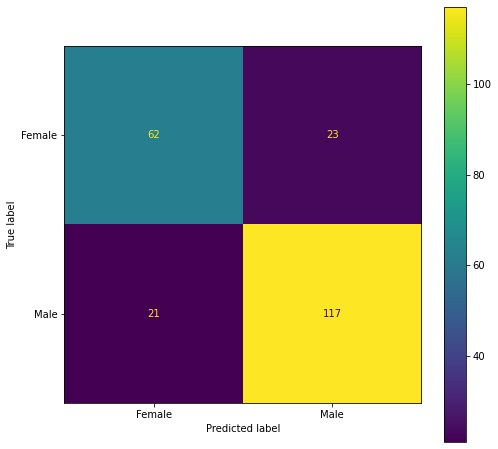

In [52]:
# Evaluating the model

cm = confusion_matrix(y_test, prediction)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Female', 'Male'])
plt.rcParams['figure.figsize'] = [8, 8]
cmd.plot()
plt.show()

### Improving ML Model Using Grid Search

In [53]:
# retrain using greed search

param_grid = {'C': np.arange(1e-05, 3, 0.1),
             'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}

# scoring = {'Accuracy': 'accuracy', 'recall': 'recall', 'precision': 'precision'}
gs = GridSearchCV(LogisticRegression(max_iter=10000), return_train_score=True,
                  param_grid=param_grid, cv=10, refit='Accuracy')

In [54]:
gs.fit(X_train, y_train)
results = gs.cv_results_

In [55]:
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)

best params: LogisticRegression(C=0.30001000000000005, max_iter=10000, solver='sag')
best params: {'C': 0.30001000000000005, 'solver': 'sag'}
best score: 0.7829262777023971


In [56]:
y_pred=gs.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      female       0.77      0.67      0.72        85
        male       0.81      0.88      0.84       138

    accuracy                           0.80       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223



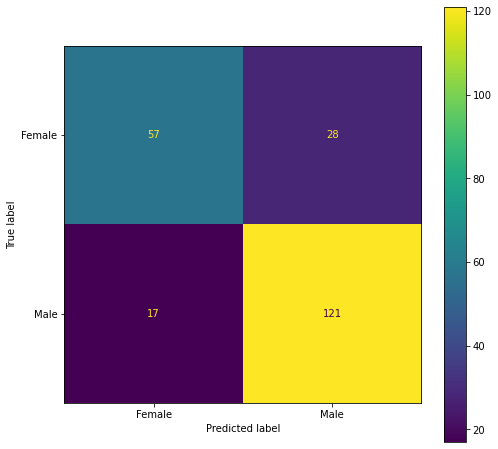

In [58]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Female', 'Male'])
plt.rcParams['figure.figsize'] = [8, 8]
cmd.plot()
plt.show()

# Save ML Model and Encoder

In [59]:
# Note it is important to save both the model and the encoder... why the encoder?
# Note: encoder is all the preprocessing steps --> WITH THERE ORDER "Order of steps and columns is important "

pickle.dump(enc, open('../encoder.pkl', 'wb'))
pickle.dump(gs, open('../model.pkl','wb'))

In [60]:
# Load just to check that model and encoder is working
encoder = pickle.load(open('../encoder.pkl', 'rb'))
model = pickle.load(open('../model.pkl', 'rb'))

In [61]:
y_preds = model.predict(X_test)

In [62]:
ss = pd.Series(y_preds, name='Predicted')

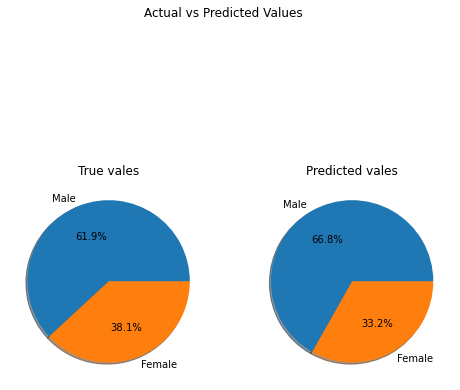

In [63]:
# plot true vs predicted values
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Actual vs Predicted Values')

# First Chart
ax1.set_title('True vales')
ax1.pie(y_test.value_counts(), labels=['Male', 'Female'], autopct='%1.1f%%', shadow=True)

# Second Chart
ax2.pie(ss.value_counts(), labels=['Male', 'Female'], autopct='%1.1f%%', shadow=True)
ax2.set_title('Predicted vales')
plt.show()